In [ ]:
import re
from collections import defaultdict
import ast
## PLACE LOG FILE HERE
log_path = "shankar_cp_timing.txt"

# updated patterns
patterns = {
    # "prefill_receive":     re.compile(r"SHRI Prefill Request (\S+)"),
    # "decode_receive":      re.compile(r"SHRI Decode Request (\S+)"),


    # "phase_1": re.compile(r"ROHAN Start of execute_model ({.*?})"), #shared by both
    # "phase_2":     re.compile(r"ROHAN Model Runner Before Recv KV \(Phase 2\): ({.*?})"), #shared by both
    # "phase_3": re.compile(r"ROHAN GPU Request Resume \(Phase 3\): ({.*?})"), #shared by both
    # "phase_4":     re.compile(r"ROHAN Model Runner Before Send KV \(Phase 4\): ({.*?})"), #shared by both
    # "phase_5":      re.compile(r"ROHAN Model Runner After Send KV \(Phase 5\): ({.*?})"), #shared by both
    # "phase_6":   re.compile(r"ROHAN End of execute_model ({.*?})"), #shared by both

    "phase_1": re.compile(
        r"ROHAN Start of execute_model\s*"
        r"\(PID:\s*(?P<pid>\d+)\)\s*"
        r"\(is prefill:\s*(?P<prefill>True|False)\)\s*"
        r"\(Phase 1\):\s*(?P<payload>\{.*?\})"
    ),
    "phase_6": re.compile(
        r"ROHAN End of execute_model\s*"
        r"\(PID:\s*(?P<pid>\d+)\)\s*"
        r"\(is prefill:\s*(?P<prefill>True|False)\)\s*"
        r"\(Phase 6\):\s*(?P<payload>\{.*?\})"
    ),


    "req_start": re.compile(
        r"ROHAN Start of Engine Step Request ID: (?P<reqid>\S+)"
        r" ON PID: (?P<pid>\d+)"
        r" at: (?P<ts>\d+\.\d+)"
    ),
    "req_end": re.compile(
        r"SHRI Finished Request ID (?P<reqid>\S+)"
        r" at (?P<ts>\d+\.\d+)"
        r" on PID: (?P<pid>\d+)"
    ),
}

# regex to extract the Unix‐style float timestamp
# still use a simple float‐timestamp puller for the other phases
ts_re = re.compile(r"(\d+\.\d+)")

def extract_events(log_file_path):
    # pid_map maps each PID to its three event‐dicts
    pid_map: dict[str, dict[str, defaultdict]] = {}

    with open(log_file_path) as f:
        for line in f:
            for name, pat in patterns.items():
                m = pat.search(line)
                if not m:
                    continue

                pid = m.group("pid")
                # initialize per‐PID buckets on first sight
                if pid not in pid_map:
                    pid_map[pid] = {
                        "prefill_events": defaultdict(list),
                        "decode_events":  defaultdict(list),
                        "request_events": defaultdict(list),
                    }
                ev_pref = pid_map[pid]["prefill_events"]
                ev_dec  = pid_map[pid]["decode_events"]
                ev_req  = pid_map[pid]["request_events"]

                # get timestamp
                if name in ("req_start", "req_end"):
                    ts = float(m.group("ts"))
                else:
                    # fallback to ts_re for phase_1/6
                    tsm = ts_re.search(line)
                    if not tsm:
                        break
                    ts = float(tsm.group(1))

                if name in ("phase_1", "phase_6"):
                    is_prefill = (m.group("prefill") == "True")
                    ids = list(ast.literal_eval(m.group("payload")).keys())
                    target = ev_pref if is_prefill else ev_dec
                    
                    print(ids[0])
                    if is_prefill:
                        target[name].append((ts, ids))
                    else:
                        target[name].append((ts, ids))
                else:
                    # req_start / req_end → just record the timestamp
                    ev_req[name].append(ts)

                break  # stop after first matching pattern

    # sort each list by timestamp
    for pid, evs in pid_map.items():
        for d in (evs["prefill_events"], evs["decode_events"]):
            for k in d:
                d[k].sort(key=lambda x: x[0])
        for k in evs["request_events"]:
            evs["request_events"][k].sort()

    # print(pid_map)
    return pid_map


def compute_intervals(events, first_time_offset=0):
    intervals = [
        (start[0] - first_time_offset, end[0] - first_time_offset)
        for start, end in zip(events['phase_1'], events['phase_6'])
    ]


    return intervals


# def compute_intervals_by_request(events, first_time_offset=0):
#     """
#     events: {
#       'phase_1': [(ts1, [reqA, reqB, …]), …],
#       'phase_6': [(ts2, [reqA, …]), …]
#     }
#     Returns: [(start_offset, end_offset, reqid), …]
#     """
#     # 1) gather all phase-1 & phase-6 times per reqid
#     starts = defaultdict(list)
#     ends   = defaultdict(list)

#     for ts, reqids in events['phase_1']:
#         for rid in reqids:
#             starts[rid].append(ts)
#     for ts, reqids in events['phase_6']:
#         for rid in reqids:
#             ends[rid].append(ts)

#     # 2) build intervals (only if we saw both phases)
#     intervals = []
#     for rid, tss in starts.items():
#         if rid in ends:
#             start = min(tss) - first_time_offset
#             end   = max(ends[rid]) - first_time_offset
#             intervals.append((start, end, rid))
#     return intervals


In [21]:
import matplotlib.pyplot as plt

def plot_combined_intervals(dict1, dict2, label1="Run 1", label2="Run 2", xmin=None, xmax=None):
    fig, ax = plt.subplots(figsize=(50, 6))

    combined = {}

    # Merge both dicts with prefixes to distinguish them
    for k, v in dict1.items():
        combined[f"{label1}: {k}"] = v
    for k, v in dict2.items():
        combined[f"{label2}: {k}"] = v

    keys = list(combined.keys())

    # Hardcoded color map for known phases (extend if needed)
    color_map = {
        'kv_send_comm': 'red',
        'kv_recv_comm': 'blue',
    }

    all_starts = [start for intervals in combined.values() for start, _ in intervals]
    all_ends   = [end for intervals in combined.values() for _, end in intervals]
    xmin = xmin if xmin is not None else min(all_starts)
    xmax = xmax if xmax is not None else max(all_ends)

    yticks = []
    ylabels = []

    for i, key in enumerate(keys):
        # Strip prefix to check base name for color mapping
        base_key = key.split(": ")[-1]
        color = color_map.get(base_key, f"C{i}")  # fallback: distinct default color
        for start, end in combined[key]:
            ax.barh(y=i, width=end - start, left=start, height=0.4, color=color)
        yticks.append(i)
        ylabels.append(key)

    ax.set_xlim(xmin, xmax)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Time (s)")
    ax.set_title("Combined Timeline of Events")
    plt.tight_layout()
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.show()

cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-ab4eb19b1cbb4d2cbfaa037beec60427-0
cmpl-ab4eb19b1cbb4d2cbfaa037beec60427-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-ab4eb19b1cbb4d2cbfaa037beec60427-0
cmpl-24336926cf9048439d7bebbe91594539-0
cmpl-ab4eb19b1cbb4d2cbfaa037beec60427-0


/tmp/ipykernel_818939/3528464022.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap     = plt.cm.get_cmap("tab20", len(all_rids))


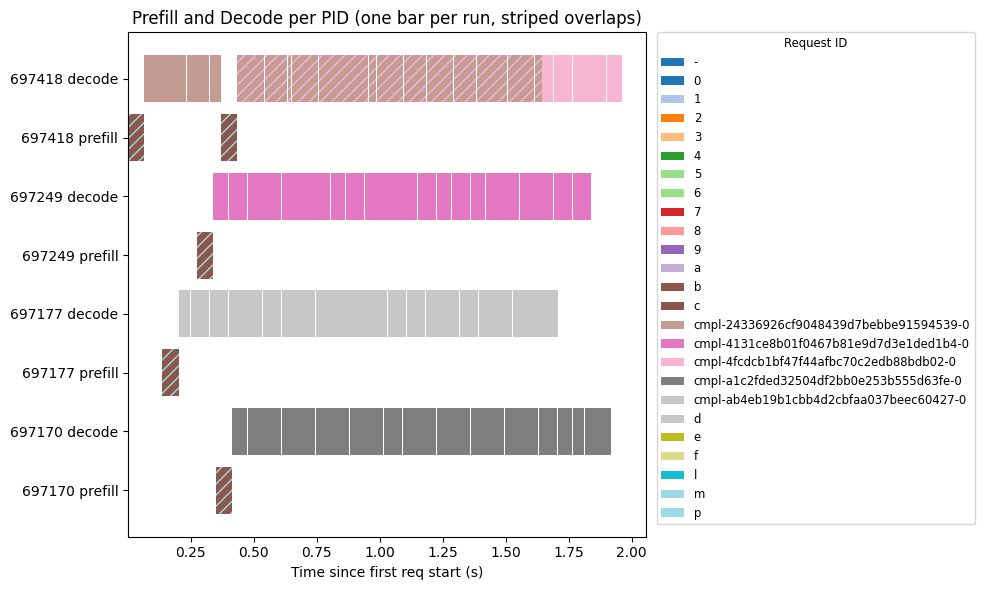

In [22]:
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Patch

def collect_intervals_by_pair(pid_map, offset, phase):
    """
    For each PID, for each (phase_1, phase_6) pair (in timestamp order),
    emit (pid, rid, start_offset, end_offset).
    """
    intervals = []
    for pid, evs in pid_map.items():
        ev = evs[f"{phase}_events"]
        # we assume ev['phase_1'] and ev['phase_6'] are sorted by ts
        for (ts1, rids1), (ts6, rids6) in zip(ev['phase_1'], ev['phase_6']):
            for rid in rids1:
                if rid in rids6:
                    intervals.append((pid, rid, ts1 - offset, ts6 - offset))
    return intervals

if __name__ == "__main__":
    pid_map = extract_events(log_path)
    first_time_offset = min(
        pid_map[p]["request_events"]["req_start"][0]
        for p in pid_map
    )

    # 1) collect one interval per *run*, not per RID collapse
    prefill_runs = collect_intervals_by_pair(pid_map, first_time_offset, phase="prefill")
    decode_runs  = collect_intervals_by_pair(pid_map, first_time_offset, phase="decode")

    print("Prefill runs:", prefill_runs)

    # 2) build a color map per request ID
    all_rids = sorted({rid for _,rid,_,_ in prefill_runs + decode_runs})
    cmap     = plt.cm.get_cmap("tab20", len(all_rids))
    rid_color = {rid: cmap(i) for i, rid in enumerate(all_rids)}

    # 3) bucket them by (pid,phase) for easy drawing + segmentation
    rows = defaultdict(list)
    for pid, rid, s, e in prefill_runs:
        rows[(pid,"prefill")].append((rid,s,e))
    for pid, rid, s, e in decode_runs:
        rows[(pid,"decode")].append((rid,s,e))

    # 4) now plot with stripes on overlaps
    fig, ax = plt.subplots(figsize=(10,6))
    yticks, ylabels = [], []
    ROW_HEIGHT = 0.8

    for i, pid in enumerate(sorted(pid_map)):
        for phase_idx, phase in enumerate(["prefill","decode"]):
            y = 2*i + phase_idx
            yticks.append(y)
            ylabels.append(f"{pid} {phase}")

            segs = rows[(pid,phase)]
            if not segs: 
                continue

            # compute all boundary points
            bounds = sorted({b for _,s,e in segs for b in (s,e)})
            for a,b in zip(bounds, bounds[1:]):
                if b <= a: 
                    continue
                # which requests cover [a,b]?
                covers = [rid for rid,s,e in segs if s <= a < e]
                if not covers:
                    continue
                if len(covers) == 1:
                    # solid fill
                    rid = covers[0]
                    ax.barh(y, b-a, left=a,
                            height=ROW_HEIGHT,
                            color=rid_color[rid],
                            edgecolor="none")
                else:
                    # two or more: base + hatch overlay
                    r1, r2 = covers[:2]
                    ax.barh(y, b-a, left=a,
                            height=ROW_HEIGHT,
                            color=rid_color[r1],
                            edgecolor="none")
                    ax.barh(y, b-a, left=a,
                            height=ROW_HEIGHT,
                            color="none",
                            edgecolor=rid_color[r2],
                            hatch="///",
                            linewidth=0)

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Time since first req start (s)")
    ax.set_title("Prefill and Decode per PID (one bar per run, striped overlaps)")

    # 5) legend
    legend_elems = [
        Patch(facecolor=rid_color[rid], label=rid)
        for rid in all_rids
    ]
    ax.legend(handles=legend_elems,
              title="Request ID",
              bbox_to_anchor=(1.02,1),
              loc="upper left",
              borderaxespad=0.0,
              fontsize="small",
              title_fontsize="small")

    plt.tight_layout()
    plt.show()

In [23]:
# if __name__ == "__main__":
#     pid_map = extract_events(log_path)
#     first_time_offset = min([pid_map[p]["request_events"]["req_start"][0] for p in pid_map ])
    
#     pid_to_intervals: dict[str, dict[str, list]] = {}

#     # --- compute true request boundaries across all PIDs ---
#     all_phase1 = []
#     all_phase6 = []
#     for pid, data in pid_map.items():
#         # grab both prefill & decode phase-1 events
#         all_phase1 += data["prefill_events"]["phase_1"]
#         all_phase1 += data["decode_events"]["phase_1"]
#         # same for phase-6
#         all_phase6 += data["prefill_events"]["phase_6"]
#         all_phase6 += data["decode_events"]["phase_6"]

#     # helper to build (start,end) per reqid
#     def compute_req_intervals_by_pid(pid_map, offset):
#         """
#         Returns a list of (start_offset, end_offset, pid, reqid)
#         by looking at the earliest phase_1 and latest phase_6 per (pid, reqid).
#         """
#         from collections import defaultdict

#         intervals = []
#         for pid, evs in pid_map.items():
#             # merge prefill & decode
#             phase1 = evs["prefill_events"]["phase_1"] + evs["decode_events"]["phase_1"]
#             phase6 = evs["prefill_events"]["phase_6"] + evs["decode_events"]["phase_6"]

#             starts = defaultdict(list)
#             ends   = defaultdict(list)
#             for ts, reqids in phase1:
#                 for rid in reqids:
#                     starts[rid].append(ts)
#             for ts, reqids in phase6:
#                 for rid in reqids:
#                     ends[rid].append(ts)

#             for rid, tss in starts.items():
#                 if rid in ends:
#                     start = min(tss) - offset
#                     end   = max(ends[rid]) - offset
#                     intervals.append((start, end, pid, rid))
#         return intervals

#     # in your __main__:
#     req_intervals = compute_req_intervals_by_pid(pid_map, first_time_offset)



#     for pid, data in pid_map.items():
#         prefill_events = data["prefill_events"]
#         decode_events = data["decode_events"]
#         request_events = data["request_events"]

#         print(decode_events)

#         # compute_intervals takes your { phase: [(ts, ids), …], … } and the offset
#         prefill_intervals = compute_intervals(prefill_events, first_time_offset)
#         decode_intervals = compute_intervals(decode_events, first_time_offset)

#         # prefill_intervals = compute_intervals_by_request(prefill_events, first_time_offset)
#         # decode_intervals = compute_intervals_by_request(decode_events, first_time_offset)

#         # print(pid, prefill_req_intervals)
#         # print(len(prefill_events["phase_1"]))
#         # print(len(decode_events["phase_1"]))
#         # print(prefill_events)
#         # print(decode_events)

#         pid_to_intervals[pid] = {
#             "prefill_intervals": prefill_intervals,
#             "decode_intervals": decode_intervals,
#             # if you also want the raw req timestamps handy:
#             "req_start": request_events.get("req_start", []),
#             "req_end": request_events.get("req_end", []),
#         }
#     # collapsed_decode_intervals = {}
#     # collapsed_prefill_intervals["GPU_TIME"] = prefill_intervals["phase_1_2"] + prefill_intervals["phase_3_4"] + prefill_intervals["phase_5_6"]
#     # collapsed_prefill_intervals["COMMUNICATION_TIME"] = prefill_intervals["kv_send_comm"] + prefill_intervals["kv_recv_comm"]
#     # collapsed_decode_intervals["GPU_TIME"] = decode_intervals["phase_1_2"] + decode_intervals["phase_3_4"] + decode_intervals["phase_5_6"]
#     # collapsed_decode_intervals["COMMUNICATION_TIME"] = decode_intervals["kv_send_comm"] + decode_intervals["kv_recv_comm"]

#     # print(collapsed_decode_intervals["COMMUNICATION_TIME"])
#     # # print counts & average durations
#     # # for name, durs in intervals.items():
#     # #     print(name, durs)
#     # #     if not durs:
#     # #         continue
#     # #     avg = sum(durs) / len(durs)
#     # #     print(f"{name:20s}: count={len(durs):3d}, avg={avg:.6f}s, min={min(durs):.6f}s, max={max(durs):.6f}s")
#     # plot_combined_intervals(
#     #     dict1=collapsed_decode_intervals,
#     #     dict2=collapsed_prefill_intervals,
#     #     label1="Decode",
#     #     label2="Prefill",
#     #     xmin=0,
#     #     xmax=last_time_offset - first_time_offset
#     # )
# fig, ax = plt.subplots(figsize=(10, 6))

# y_positions = []
# y_labels = []

# # Pick a distinct color per PID
# color_map = plt.cm.get_cmap('Accent', len(pid_to_intervals))

# for i, (pid, intervals) in enumerate(sorted(pid_to_intervals.items())):
#     base = i * 2
#     pid_color = color_map(i)

#     # Prefill bars
#     for start, end in intervals['prefill_intervals']:
#         ax.barh(base, end - start, left=start, color=pid_color)
#     y_positions.append(base)
#     y_labels.append(f"{pid} prefill")

#     # Decode bars
#     for start, end in intervals['decode_intervals']:
#         ax.barh(base + 1, end - start, left=start, color=pid_color)
#     y_positions.append(base + 1)
#     y_labels.append(f"{pid} decode")


# # # --- overlay vertical lines on your existing ax ---
# # for start, end in req_intervals:
# #     ax.axvline(x=start, linestyle="--", linewidth=0.8, alpha=0.6,
# #                label="req start" if start == req_intervals[0][0] else "")
# #     ax.axvline(x=end,   linestyle="-.", linewidth=0.8, alpha=0.6,
# #                label="req end"   if end   == req_intervals[0][1] else "")



# # 1) build a consistent color map for your PIDs
# pid_list = sorted(pid_to_intervals.keys())
# cmap    = plt.cm.get_cmap("Accent", len(pid_list))
# pid_color = {pid: cmap(i) for i, pid in enumerate(pid_list)}

# # 2) find top of plot so we can put text above it
# ymin, ymax = ax.get_ylim()
# text_y = ymax + 0.5  # tweak as needed

# # 3) draw & label
# first_start = True
# first_end   = True
# for start, end, pid, rid in req_intervals:
#     color = pid_color[pid]
#     # vertical lines
#     ax.axvline(start, color=color, linestyle="--",  linewidth=0.8, alpha=0.7, label="Request Start" if first_start else None)
#     ax.axvline(  end, color=color, linestyle="-.", linewidth=0.8, alpha=0.7, label="Request End" if first_end else None)
#     # label at the top
#     # ax.text(
#     #     (start+end)/2, text_y,
#     #     f"{pid}:{rid}",
#     #     rotation=90,
#     #     va="bottom", ha="center",
#     #     fontsize=5,
#     #     color=color,
#     # )
#     first_start = False
#     first_end   = False

# # now draw the legend
# ax.legend(loc="upper right", fontsize=8)

# # 4) extend y‐limits so labels aren't cut off
# ax.set_ylim(ymin, text_y + 0.5)

# ax.set_yticks(y_positions)
# ax.set_yticklabels(y_labels)
# ax.set_xlabel('Time since first req start (s)')
# ax.set_ylabel('PID and Phase')
# ax.set_title('Prefill and Decode Scheduling per PID')
# plt.tight_layout()
# plt.show()
